# Potential method for calculating Betti numbers

### 1. Input
The first problem we'll be dealing with is how to get an *input* in to the code to begin with. I propose using a class `Graph` from the package **NetworkX** which can create a graph easily and simply with built-in methods such as `add_edge`, `add_node`, and `draw`, and then creating a way to convert this to a matrix over field $\mathbb{F}_2$. This way, we can make it simple to create test graphs without having to create the matrices by hand. This could look like this:

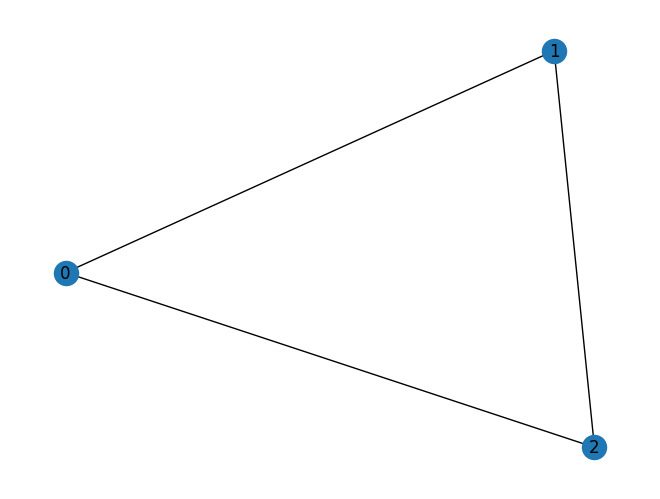

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

type Graph = nx.classes.graph.Graph
type Matrix = np.ndarray

G = nx.Graph()
G.add_nodes_from([0, 1, 2])
G.add_edges_from([(0, 1), 
                  (0, 2), 
                  (1, 2)])

nx.draw(G, with_labels=True)
plt.show()

You can even add colors to this representation.

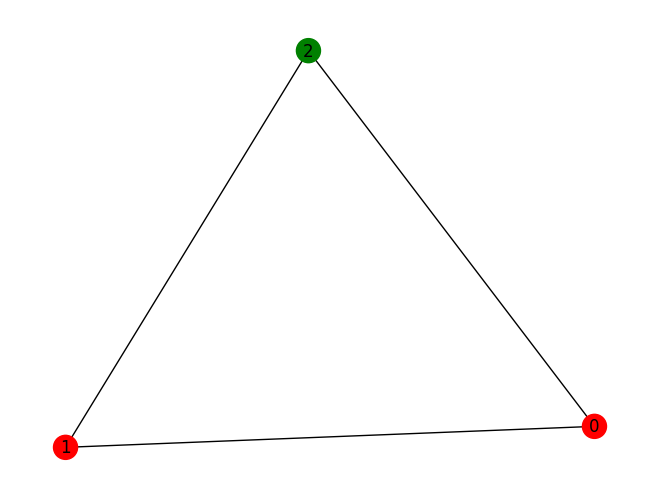

In [63]:
groupA = {0, 1}
groupB = {2}

node_colors = []

for v in G.nodes:
    if v in groupA:
        node_colors.append('red')
    if v in groupB:
        node_colors.append('green')

options = {
    'node_color': node_colors
}

nx.draw(G, with_labels = True, **options)
plt.show()

### 2. Determining Betti numbers


In [64]:
class GraphMatrix:
    """
    Input graph must be a NetworkX graph, and vertices must have form 0, 1, 2, ...
    """
    def __init__(self, graph: Graph):
        self.graph: Graph = graph
        self.vertices: set[int] = set(self.graph.nodes)
        self.edges: list[set[int]] = set(self.graph.edges)
        self.matrix: Matrix = self.graph_matrix(self.graph) % 2
        
    @staticmethod
    def graph_matrix(G: Graph) -> Matrix:
        """
        Static method `graph_matrix` is for taking any NetworkX graph and turning it into a edge space represented by a matrix, or a **NumPy Array**
        """
        g: list[list[int]] = []
        for edge in G.edges:
            vectorized = [0 for _ in list(G.nodes)]
            for v in edge:
                vectorized[v] = 1
            g.append(vectorized)
        return np.array(g).transpose()
    
    def dimension_kernel_boundary_1(self) -> int:
        return len(self.edges) - self.matrix.ndim
        
    
            


In [65]:
graph = GraphMatrix(G)
print(graph.matrix)

[[1 1 0]
 [1 0 1]
 [0 1 1]]


In [66]:
# This will print the dimension of the kernel of the 1-dimensional boundary map, for our graph G that is 1
print(graph.dimension_kernel_boundary_1())

1


Find all cliques in a graph.

In [ ]:
G = nx.gnm_random_graph(50, 200)
  
cliques = [clique for clique in nx.enumerate_all_cliques(G)][::-1]
cliques

[[34, 36, 37, 45],
 [12, 22, 26, 37],
 [11, 17, 39, 46],
 [4, 16, 37, 45],
 [2, 11, 32, 49],
 [2, 11, 22, 32],
 [2, 11, 22, 29],
 [36, 37, 45],
 [35, 44, 48],
 [35, 44, 46],
 [34, 37, 45],
 [34, 36, 45],
 [34, 36, 37],
 [32, 44, 49],
 [32, 36, 49],
 [29, 46, 47],
 [26, 31, 37],
 [26, 29, 47],
 [26, 29, 31],
 [24, 31, 33],
 [22, 34, 37],
 [22, 26, 37],
 [22, 26, 29],
 [19, 44, 48],
 [19, 44, 46],
 [17, 39, 46],
 [17, 39, 42],
 [17, 19, 46],
 [16, 37, 45],
 [16, 31, 37],
 [16, 19, 37],
 [14, 29, 48],
 [14, 29, 47],
 [14, 24, 47],
 [12, 26, 47],
 [12, 26, 37],
 [12, 22, 37],
 [12, 22, 26],
 [11, 39, 46],
 [11, 32, 49],
 [11, 29, 46],
 [11, 22, 32],
 [11, 22, 29],
 [11, 18, 22],
 [11, 17, 46],
 [11, 17, 39],
 [11, 17, 33],
 [11, 17, 32],
 [9, 41, 49],
 [9, 36, 49],
 [9, 23, 29],
 [9, 17, 42],
 [8, 39, 46],
 [8, 39, 43],
 [8, 38, 39],
 [8, 36, 40],
 [8, 36, 38],
 [8, 32, 36],
 [8, 31, 39],
 [8, 21, 43],
 [8, 21, 41],
 [7, 12, 23],
 [6, 35, 44],
 [6, 35, 36],
 [6, 28, 36],
 [6, 26, 44],
 [6,

I decided to implement my algorithm that I was attempting to explain earlier. I will also provide some intuition for exactly why this represents the boundary map we are looking for.

In [74]:
def betti_numbers(G):
    """
    Given a graph, compute all of its non-trivial Betti numbers.
    """

    # first, find all cliques in the graph, sorted in descending order by size
    cliques = [clique for clique in nx.enumerate_all_cliques(G)][::-1]

    # we need to keep track of which positions in our matrices our cliques correspond to; we can arbitrarily define these so long as they remain consistent
    # define one dictionary for each size clique in our graph
    max_clique_size = max(map(len, cliques))
    position = [dict() for _ in range(max_clique_size)]

    k = max_clique_size # start with the max sized cliques
    i = 0 # index the cliques of size k
    j = 0 # index the positions

    for clique in cliques:
        if len(clique) < k:
            k = len(clique) # move to next size k
            j += 1 # move to next position in list of dictionaries
            i = 0 # reset k-clique index for new k
        
        curr_dict = position[j]
        curr_dict[tuple(clique)] = i # set the current clique to have value i in the appropriate dictionary
        i += 1


    
    # we can initialize our boundary matrices with zeros
    Matrix = [np.zeros((len(position[i].keys()), len(position[i+1].keys()))) for i in range(max_clique_size - 1)]
    
    """
    Now, we need to loop through the cliques again and fill in the matrices.
    """

    k = max_clique_size
    j = 0
    for j in range(len(position) - 1):
        for clique, pos in position[j].items():
            for v in clique:
                face = list(clique)
                face.remove(v)

                Matrix[j][pos, position[j + 1][tuple(face)]] = 1
        

    ranks = np.zeros(len(Matrix))
    nullities = np.zeros(len(Matrix))
    for i, M in enumerate(Matrix):
        print(M)
        rank = np.linalg.matrix_rank(M)
        nullity = M.shape[1] - rank

        ranks[i] = rank
        nullities[i] = nullity
    
    result = np.zeros(max_clique_size)
    result[1:-1] = nullities[:-1] - ranks[1:]

    return result

In [76]:
G = nx.complete_graph(4)
betti_numbers(G)

[[1. 1. 1. 1.]]
[[1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1.]]
[[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]]


array([ 0., -1., -2.,  0.])

In [68]:
import networkx as nx
import numpy as np

def betti_numbers(G):
    # 1. GENERATE CLIQUES
    # Get all cliques. Sort by size for easier grouping (optional but helpful)
    cliques = list(nx.enumerate_all_cliques(G))
    
    # Find the maximum dimension (size of largest clique)
    max_dim = max(len(c) for c in cliques)
    
    # 2. BUILD POSITIONS (The Map)
    # position[k] will hold a dict: {clique_tuple: index} for cliques of size k
    # We use (max_dim + 1) so we can index directly by size (e.g., position[3] for size 3)
    position = [dict() for _ in range(max_dim + 1)]
    
    for clique in cliques:
        k = len(clique)
        # Sort clique tuple to ensure uniqueness (e.g., (1,2) is same as (2,1))
        clique_tuple = tuple(sorted(clique))
        
        # Assign the next available index for this size
        idx = len(position[k]) 
        position[k][clique_tuple] = idx

    # 3. BUILD BOUNDARY MATRICES
    # D[k] maps (k)-cliques to (k-1)-cliques
    # Rows: (k-1)-cliques, Cols: k-cliques
    boundary_matrices = []
    
    # We iterate from k=1 up to max_dim. 
    # (Note: Betti numbers are usually indexed by dimension. 
    # k-clique is dimension k-1. So size 2 (edge) is dim 1 boundary map)
    for k in range(2, max_dim + 1):
        # Rows = number of (k-1)-cliques
        num_rows = len(position[k-1])
        # Cols = number of k-cliques
        num_cols = len(position[k])
        
        # Create matrix for boundary operator d_k: C_{k-1} -> C_{k-2}
        # Wait, standard TDA convention: 
        # Boundary matrix D_k maps k-simplices (cols) to (k-1)-simplices (rows)
        mat = np.zeros((num_rows, num_cols))
        
        for clique, col_idx in position[k].items():
            # For each k-clique, find its (k-1) faces
            # A face is formed by removing exactly one vertex
            for i in range(len(clique)):
                # Create face by excluding the i-th vertex
                face = clique[:i] + clique[i+1:]
                
                # Find the row index for this face
                if face in position[k-1]:
                    row_idx = position[k-1][face]
                    mat[row_idx, col_idx] = 1
                else:
                    print(f"Error: Face {face} not found in positions!")
        
        boundary_matrices.append(mat)

    # 4. COMPUTE BETTI NUMBERS
    # B_k = dim(Kernel(d_k)) - dim(Image(d_{k+1}))
    # Note: dim(Kernel(d_k)) = nullity of D_k
    # dim(Image(d_{k+1})) = rank of D_{k+1}
    
    betti_nums = []
    
    # Calculate ranks and nullities
    # We pad the list of matrices with a zero-map at the start and end for simplified indexing
    # But let's just do it explicitly for the list we have.
    
    # boundary_matrices[0] is from Size 2 -> Size 1 (Edges -> Vertices) (Boundary of 1-simplices)
    # boundary_matrices[1] is from Size 3 -> Size 2 (Triangles -> Edges) (Boundary of 2-simplices)
    
    ranks = [np.linalg.matrix_rank(M) for M in boundary_matrices]
    
    # For Betti_0 (Connected Components):
    # num_vertices - rank(D_1)
    num_vertices = len(position[1])
    b0 = num_vertices - ranks[0]
    betti_nums.append(b0)
    
    # For Betti_k (k > 0):
    # nullity(D_k) - rank(D_{k+1})
    # nullity(D_k) = num_cols(D_k) - rank(D_k)
    
    for i in range(len(boundary_matrices) - 1):
        # D_k is boundary_matrices[i]
        # D_{k+1} is boundary_matrices[i+1]
        
        num_cols = boundary_matrices[i].shape[1] # number of k-simplices
        rank_current = ranks[i]
        rank_next = ranks[i+1]
        
        nullity_current = num_cols - rank_current
        bk = nullity_current - rank_next
        betti_nums.append(bk)

    return betti_nums

# Test
G = nx.cycle_graph(4) # A square loop. Should have B0=1, B1=1
print(betti_numbers(G))

[np.int64(1)]
